In [340]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# 1. Introduction

### Classifiers

Support Vector Machine

Decision Tree

### DataSets

I chose a database of student info, and my goal is to predict whether performs well. Source: [UCI Data Repo](http://archive.ics.uci.edu/ml/datasets/Student+Performance#)

The label is edbile or poisonous. Here are some info about the data, quote from [math performance](./student/student-mat.csv) and [Portuguese performance](./student/student-por.csv)

## a) Import Data

In [342]:
def replace_str(target, old, new, delete=None):
    
    intab = old
    outtab = new
    transtable = str.maketrans(intab, outtab, delete)
    
    return target.translate(transtable)

In [4]:
grade = pd.read_csv('./student/student-mat.csv',sep=';')
grade.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
grade.shape
grade.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
def has_passed(score):
    return 1 if score >= 10 else 0

def got_A(score):
    return 1 if score >= 16 else 0

grade['label'] = grade.G3.apply(lambda x: has_passed(x)).astype('int')

In [7]:
#grade.to_csv('./stuperf_math.csv')

In [541]:
#grade_X = grade.drop(columns=['G1','G2','G3','label'])
grade_X = grade.drop(columns=['G2','G3','label'])
grade_y = grade['label']

In [9]:
grade_y.value_counts()

1    265
0    130
Name: label, dtype: int64

## b) Data Cleaning & Missing Values

As described in the source, there are no missing values for this dataset. However, the data format is mixed. We need to clean them up.

### One-hot encoding

Since all of the features are categorical features, I will turn them into binary features using 1-hot encoding.

In [542]:
grade_X = pd.get_dummies(grade_X, columns=['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic','Mjob', 'Fjob', 'reason', 'guardian'])
grade_X.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,4,4,2,2,0,4,3,4,1,...,0,0,1,1,0,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,0,1,0,0,0,1,0,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,0,0,1,0,0,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,0,1,0,0,0,1,0
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,0,1,0,0,1,0,0


### Normalization

In [11]:
# normalize data
scaler = MinMaxScaler()
grade_X = scaler.fit_transform(grade_X)
#grade_train_X = scaler.fit_transform(grade_train_X)
#grade_test_X = scaler.transform(grade_test_X)

In [12]:
# no normalize data
#grade_X = grade_X.astype('double')
#grade_X = (grade_X-grade_X.min())/(grade_X.max() - grade_X.min())

### Data Splitting

In [134]:
# Split data in 80/20
grade_train_X, grade_test_X, grade_train_y, grade_test_y = \
  train_test_split(grade_X, grade_y, random_state=2018, test_size=0.25)

Features 

1. school - student's school (**binary**: 1 - 'GP' - Gabriel Pereira or 0 - 'MS' - Mousinho da Silveira) 

2. sex - student's sex (**binary**: 1 - 'F' - female or 0 - 'M' - male) 

3. age - student's age (numeric: from 15 to 22) 

4. address - student's home address type (**binary**: 1 - 'U' - urban or 0 - 'R' - rural) 

5. famsize - family size (**binary**: 1 - 'LE3' - less or equal to 3 or 0 - 'GT3' - greater than 3) 

6. Pstatus - parent's cohabitation status (**binary**: 1 - 'T' - living together or 0 - 'A' - apart) 

7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education) 

8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education) 

9. Mjob - mother's job **1-hot**(nominal: 'teacher','health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 

10. Fjob - father's job **1-hot**(nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 

11. reason - reason to choose this school **1-hot**(nominal: close to 'home', school 'reputation', 'course' preference or 'other') 

12. guardian - student's guardian **1-hot**(nominal: 'mother', 'father' or 'other') 

13. traveltime - home to school travel time **1-hot**(numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 

14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 

15. failures - number of past class failures (numeric: n if 1<=n<3, else 4) 

16. schoolsup - extra educational support **1-0**(**binary**: yes or no) 

17. famsup - family educational support **1-0**(**binary**: yes or no) 

18. paid - extra paid classes within the course subject (Math or Portuguese) **1-0**(**binary**: yes or no) 

19. activities - extra-curricular activities **1-0**(**binary**: yes or no) 

20. nursery - attended nursery school **1-0**(**binary**: yes or no) 

21. higher - wants to take higher education **1-0**(**binary**: yes or no) 

22. internet - Internet access at home **1-0**(**binary**: yes or no) 

23. romantic - with a romantic relationship **1-0**(**binary**: yes or no) 

24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 

25. freetime - free time after school (numeric: from 1 - very low to 5 - very high) 

26. goout - going out with friends (numeric: from 1 - very low to 5 - very high) 

27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 

28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 

29. health - current health status (numeric: from 1 - very bad to 5 - very good) 

30. absences - number of school absences (numeric: from 0 to 93) 

## c) Data Processing 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.cross_decomposition import PLSCanonical
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [135]:
names = ["Nearest Neighbors", "FLD","Linear SVM", 
         "Logistic Regression","Decision Tree", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(2),
    LinearDiscriminantAnalysis(n_components=5),
    #PLSCanonical(n_components=2),
    SVC(kernel="linear"),
    LogisticRegression(),
    DecisionTreeClassifier(max_leaf_nodes=10),
    AdaBoostClassifier()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(grade_train_X, grade_train_y)
    #score = clf.score(ks_test_X, ks_test_y)
    print(name)
    print(clf.score(grade_train_X, grade_train_y))
    print(clf.score(grade_test_X, grade_test_y))

Nearest Neighbors
0.7871621621621622
0.5050505050505051
FLD
0.8952702702702703
0.7676767676767676
Linear SVM
0.902027027027027
0.7474747474747475
Logistic Regression
0.8885135135135135
0.7373737373737373
Decision Tree
0.9087837837837838
0.8181818181818182
AdaBoost
0.9324324324324325
0.7878787878787878


/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Tune Parameter (Cross Validation)

In [16]:
def tune_para_cv(estimator, X, y, parameter_name ,parameters, k_fold = 4):
    
    from sklearn.model_selection import KFold
    from sklearn.model_selection import GridSearchCV
    
    tuned_parameters = [{parameter_name: parameters}]
    n_folds = k_fold

    clf = GridSearchCV(estimator, tuned_parameters, cv=n_folds, refit=False)
    clf.fit(X, y)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']
    plt.figure().set_size_inches(8, 6)

    plt.plot(parameters, scores)

    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)

    plt.plot(parameters, scores + std_error, 'b--')
    plt.plot(parameters, scores - std_error, 'b--')

    # alpha=0.2 controls the translucency of the fill color
    #plt.fill_between(cc, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('CV score +/- std error')
    plt.xlabel(parameter_name)
    plt.axhline(np.max(scores), linestyle='--', color='.5')
    plt.xlim([parameters[0], parameters[-1]])

    plt.show()

In [159]:
def print_cv(scores):
    print(scores)
    print('Mean:\t %f' % np.mean(scores))
    print('Var :\t %f' % np.var(scores))

In [165]:
kfold = 5

### Classifier 1: SVM

In [414]:
lin_svm = LinearSVC(random_state=2018, loss='hinge')
lin_svm.fit(grade_train_X,grade_train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=2018, tol=0.0001, verbose=0)

In [412]:
print(lin_svm.score(grade_train_X,grade_train_y))
print(lin_svm.score(grade_test_X,grade_test_y))

0.8986486486486487
0.7575757575757576


In [422]:
scores = cross_val_score(lin_svm, grade_X, grade_y, cv=kfold)
print_cv(scores)

[0.75949367 0.75949367 0.70886076 0.78481013 0.92405063]
Mean:	 0.787342
Var :	 0.005281


#### Tuning C

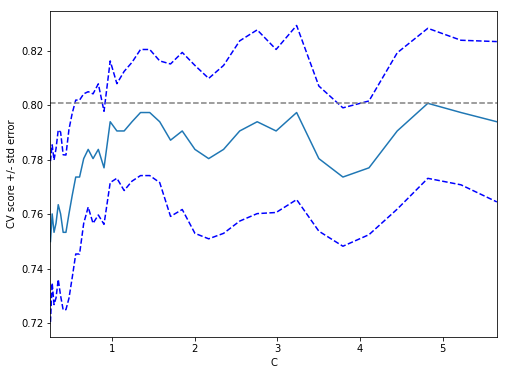

In [388]:
cc = np.logspace(-2.0, 2.5, num=40, base=2)
tune_para_cv(lin_svm, grade_train_X, grade_train_y, 'C', cc)

In [389]:
cc

array([0.25      , 0.27081595, 0.29336512, 0.31779181, 0.34425236,
       0.37291612, 0.40396654, 0.43760232, 0.47403876, 0.51350903,
       0.55626574, 0.60258254, 0.65275585, 0.70710678, 0.76598318,
       0.82976185, 0.89885097, 0.97369272, 1.05476608, 1.14258991,
       1.23772629, 1.34078408, 1.45242286, 1.5733571 , 1.70436079,
       1.84627235, 2.        , 2.1665276 , 2.34692092, 2.54233447,
       2.7540189 , 2.98332898, 3.23173229, 3.5008186 , 3.79231006,
       4.1080722 , 4.4501259 , 4.8206603 , 5.22204679, 5.65685425])

In [548]:
# cross validation scores
lin_svm_tuned = LinearSVC(random_state=2018,C=5)
lin_svm_tuned.fit(grade_train_X, grade_train_y)
#scores = lin_svm_tuned.score(grade_test_X, grade_test_y)
print(lin_svm_tuned.score(grade_train_X,grade_train_y))
print(lin_svm_tuned.score(grade_test_X,grade_test_y))
#print(scores)

0.9222972972972973
0.797979797979798


In [421]:
scores = cross_val_score(lin_svm_tuned, grade_X, grade_y, cv=kfold)
print_cv(scores)

[0.78481013 0.78481013 0.78481013 0.79746835 0.92405063]
Mean:	 0.815190
Var :	 0.002987


In [403]:
def plot_roc(clf ,data, label, plot=False):
    score = clf.decision_function(data)
    fpr, tpr, thresholds = roc_curve(label, score)
    if plot:
        plt.plot(fpr,tpr)
    auc = roc_auc_score(label, score)
    if plot:
        print('auc score: '+str(auc))
    return fpr,tpr,auc

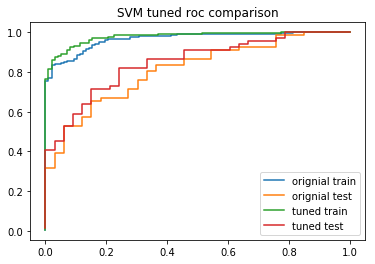

original test auc score:	0.810376
tuned test auc score   :	0.846189


In [405]:
fpr_tr,tpr_tr,auc_tr = plot_roc(lin_svm, grade_train_X, grade_train_y)
fpr_tt,tpr_tt,auc_tt = plot_roc(lin_svm, grade_test_X, grade_test_y)
svm_fpr_tr,svm_tpr_tr,svm_auc_tr = plot_roc(lin_svm_tuned, grade_train_X, grade_train_y)
svm_fpr_tt,svm_tpr_tt,svm_auc_tt = plot_roc(lin_svm_tuned, grade_test_X, grade_test_y)

plt.plot(fpr_tr,tpr_tr,label='orignial train')
plt.plot(fpr_tt,tpr_tt,label='orignial test')
plt.plot(svm_fpr_tr,svm_tpr_tr,label='tuned train')
plt.plot(svm_fpr_tt,svm_tpr_tt,label='tuned test')
plt.title('SVM tuned roc comparison')
plt.legend()
plt.show()
print('original test auc score:\t%f' %auc_tt)
print('tuned test auc score   :\t%f' %svm_auc_tt)

In [558]:
cm = confusion_matrix(grade_test_y, lin_svm_tuned.predict(grade_test_X))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

svm_recall = tp/(tp+fn)
svm_precision = tp/(tp+fp)
print('Recall   \t%f'%svm_recall) 
print('Precision\t%f'%svm_precision)

22 11 9 57
Recall   	0.863636
Precision	0.838235


In [295]:
pd.DataFrame(cm)

,0,1
0,19,14
1,9,57


In [310]:
#lin_svm_tuned.support_
#plt.scatter(lin_svm_tuned.support_,grade_train_y[lin_svm_tuned.support_])

### Improving performance

In [426]:
scores = cross_val_score(lin_svm, grade_train_X, grade_train_y, cv=kfold)
print_cv(scores)

[0.71666667 0.93333333 0.81355932 0.81355932 0.82758621]
Mean:	 0.820941
Var :	 0.004732


In [436]:
# feature selection
for n in np.linspace(35,56,20,dtype=int):
    pca = PCA(n_components=n)
    grade_pca_X = pca.fit(grade_train_X).transform(grade_train_X)
    # cross validation scores
    lin_svm_tuned = LinearSVC(random_state=2018,loss='hinge')
    scores = cross_val_score(lin_svm_tuned, grade_pca_X, grade_train_y, cv=5)
    print(n)
    print_cv(scores)

35
[0.66666667 0.78333333 0.74576271 0.79661017 0.81034483]
Mean:	 0.760544
Var :	 0.002666
36
[0.75       0.86666667 0.81355932 0.77966102 0.87931034]
Mean:	 0.817839
Var :	 0.002448
37
[0.76666667 0.88333333 0.83050847 0.83050847 0.81034483]
Mean:	 0.824272
Var :	 0.001416
38
[0.75       0.91666667 0.83050847 0.81355932 0.82758621]
Mean:	 0.827664
Var :	 0.002832
39
[0.71666667 0.93333333 0.79661017 0.83050847 0.82758621]
Mean:	 0.820941
Var :	 0.004847
40
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var :	 0.004828
41
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var :	 0.004828
42
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var :	 0.004828
43
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var :	 0.004828
44
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var :	 0.004828
46
[0.71666667 0.93333333 0.79661017 0.81355932 0.82758621]
Mean:	 0.817551
Var 

In [463]:
pca = PCA(n_components=37)
grade_pca_X = pca.fit(grade_train_X).transform(grade_train_X)
# cross validation scores
#lin_svm = LinearSVC(random_state=2018,loss='hinge')
scores = cross_val_score(lin_svm, grade_pca_X, grade_train_y, cv=5)
print_cv(scores)

[0.76666667 0.88333333 0.83050847 0.83050847 0.81034483]
Mean:	 0.824272
Var :	 0.001416


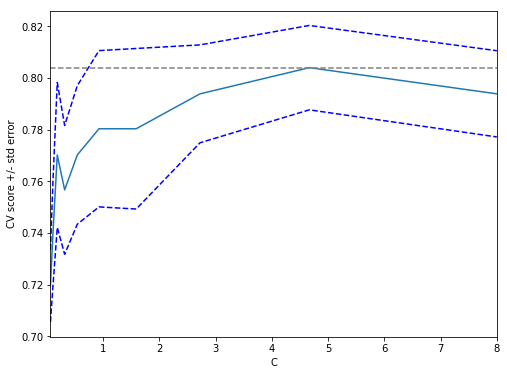

In [466]:
cc = np.logspace(-4.0, 3.0, num=10, base=2.0)
tune_para_cv(lin_svm, grade_pca_X, grade_train_y, 'C', cc)

In [446]:
cc

array([6.25000000e-02, 1.45816130e-01, 3.40197500e-01, 7.93700526e-01,
       1.85174942e+00, 4.32023896e+00, 1.00793684e+01, 2.35157519e+01,
       5.48636149e+01, 1.28000000e+02])

In [467]:
# cross validation scores
lin_svm_pca = LinearSVC(random_state=2018,loss='hinge', C=5)
lin_svm_pca.fit(grade_pca_X, grade_train_y)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=2018, tol=0.0001, verbose=0)

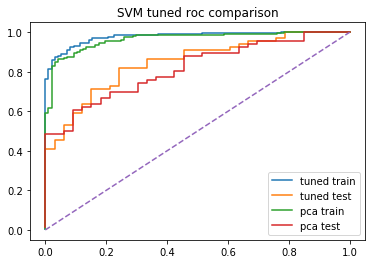

auc score: 0.815426997245179


In [468]:
pca_fpr_tr,pca_tpr_tr,pca_auc_tr = plot_roc(lin_svm_pca, grade_pca_X, grade_train_y)
pca_fpr_tt,pca_tpr_tt,pca_auc_tt = plot_roc(lin_svm_pca, pca.transform(grade_test_X), grade_test_y)

svm_fpr_tr,svm_tpr_tr,svm_auc_tr = plot_roc(lin_svm_tuned, grade_train_X, grade_train_y)
svm_fpr_tt,svm_tpr_tt,svm_auc_tt = plot_roc(lin_svm_tuned, grade_test_X, grade_test_y)

plt.plot(svm_fpr_tr,svm_tpr_tr,label='tuned train')
plt.plot(svm_fpr_tt,svm_tpr_tt,label='tuned test')

plt.plot(pca_fpr_tr,pca_tpr_tr,label='pca train')
plt.plot(pca_fpr_tt,pca_tpr_tt,label='pca test')

plt.title('SVM tuned roc comparison')
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

print('auc score: ' + str(pca_auc_tt))

In [556]:
grade_test_y.shape

(99,)

In [557]:
cm = confusion_matrix(grade_test_y, lin_svm_pca.predict(pca.transform(grade_test_X)))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

pca_recall = tp/(tp+fn)
pca_precision = tp/(tp+fp)
print(pca_recall, pca_precision)

17 16 8 58
0.8787878787878788 0.7837837837837838


In [472]:
scores = cross_val_score(lin_svm_pca, pca.transform(grade_X), grade_y, cv=kfold)

print_cv(scores)

[0.73417722 0.79746835 0.69620253 0.79746835 0.63291139]
Mean:	 0.731646
Var :	 0.003935


### SFS

In [473]:
grade_sfs_X = SelectKBest(chi2, k=10).fit_transform(grade_train_X, grade_train_y)
grade_sfs_X

array([[0.33333333, 0.75      , 0.375     , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.25      , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.3125    , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.75      , 0.8125    , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5       , 0.4375    , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.1875    , ..., 0.        , 0.        ,
        0.        ]])

In [492]:
# feature selection
for n in np.linspace(2,40,20,dtype=int):
    grade_sfs_X = SelectKBest(chi2, k=n).fit_transform(grade_train_X, grade_train_y)
    # cross validation scores
    lin_svm_tuned = LinearSVC(random_state=2018,loss='hinge')
    scores = cross_val_score(lin_svm_tuned, grade_sfs_X, grade_train_y, cv=5)
    print(n)
    print_cv(scores)

2
[0.73333333 0.9        0.86440678 0.79661017 0.89655172]
Mean:	 0.838180
Var :	 0.004128
4
[0.73333333 0.95       0.88135593 0.79661017 0.87931034]
Mean:	 0.848122
Var :	 0.005657
6
[0.75       0.9        0.89830508 0.86440678 0.87931034]
Mean:	 0.858404
Var :	 0.003109
8
[0.78333333 0.88333333 0.81355932 0.77966102 0.84482759]
Mean:	 0.820943
Var :	 0.001527
10
[0.76666667 0.9        0.86440678 0.81355932 0.87931034]
Mean:	 0.844789
Var :	 0.002341
12
[0.76666667 0.91666667 0.86440678 0.81355932 0.79310345]
Mean:	 0.830881
Var :	 0.002867
14
[0.78333333 0.9        0.81355932 0.83050847 0.81034483]
Mean:	 0.827549
Var :	 0.001541
16
[0.76666667 0.91666667 0.84745763 0.84745763 0.82758621]
Mean:	 0.841167
Var :	 0.002303
18
[0.78333333 0.9        0.81355932 0.84745763 0.84482759]
Mean:	 0.837836
Var :	 0.001513
20
[0.75       0.91666667 0.83050847 0.83050847 0.84482759]
Mean:	 0.834502
Var :	 0.002806
22
[0.75       0.91666667 0.83050847 0.83050847 0.84482759]
Mean:	 0.834502
Var :	 0

In [494]:
selectKBest = SelectKBest(chi2, k=6)
grade_sfs_X = selectKBest.fit_transform(grade_train_X, grade_train_y)
# cross validation scores
#lin_svm = LinearSVC(random_state=2018,loss='hinge')
scores = cross_val_score(lin_svm_tuned, grade_sfs_X, grade_train_y, cv=5)
print_cv(scores)

[0.75       0.9        0.89830508 0.86440678 0.87931034]
Mean:	 0.858404
Var :	 0.003109


In [524]:
pd.DataFrame(selectKBest.scores_).sort_values(by=[0],ascending=False).head(6)

,0
5,21.257189
13,11.245360
34,4.883454
56,3.503393
46,2.799570
40,2.306227


In [536]:
cc[[1,2]]

array([0.20621515, 0.3401975 ])

In [543]:
grade_X.columns[[5,13,34,56,46,40]]

Index(['failures', 'G1', 'higher_no', 'guardian_other', 'Fjob_health',
       'Mjob_at_home'],
      dtype='object')

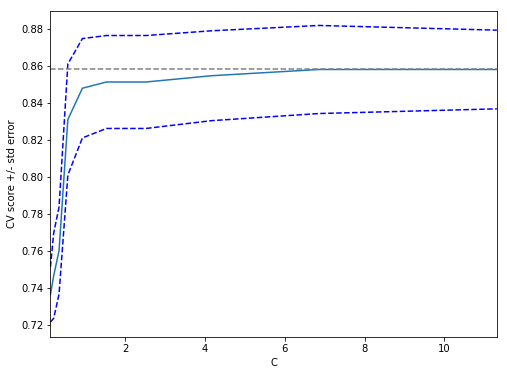

In [498]:
cc = np.logspace(-3.0, 3.5, num=10, base=2.0)
tune_para_cv(lin_svm_tuned, grade_sfs_X, grade_train_y, 'C', cc)

In [499]:
lin_svm_sfs = LinearSVC(random_state=2018,loss='hinge',C=8)
lin_svm_sfs.fit(grade_ffs_X, grade_train_y)
#lin_svm_tuned.score(selectKBest.transform(grade_test_X), grade_test_y)

LinearSVC(C=8, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=2018, tol=0.0001, verbose=0)

In [500]:
cm = confusion_matrix(grade_test_y, lin_svm_sfs.predict(selectKBest.transform(grade_test_X)))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
sfs_recall = tp/(tp+fn)
sfs_precision = tp/(tp+fp)
print(sfs_recall, sfs_precision)

23 10 11 55
0.8333333333333334 0.8461538461538461


In [501]:
#lin_svm_tuned = LinearSVC(random_state=2018,loss='hinge', C=0.75)
sfs_scores = cross_val_score(lin_svm_sfs, selectKBest.transform(grade_X), grade_y, cv=5)
print_cv(sfs_scores)

[0.82278481 0.82278481 0.79746835 0.84810127 0.88607595]
Mean:	 0.835443
Var :	 0.000897


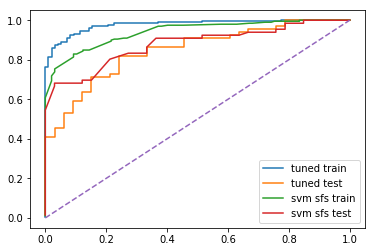

svm auc score: 	0.8461891643709825
sfs auc score: 	0.8774104683195593


In [550]:
svm_fpr_tr,svm_tpr_tr,svm_auc_tr = plot_roc(lin_svm_tuned, grade_train_X, grade_train_y)
svm_fpr_tt,svm_tpr_tt,svm_auc_tt = plot_roc(lin_svm_tuned, grade_test_X, grade_test_y)
sfs_fpr_tr,sfs_tpr_tr,sfs_auc_tr = plot_roc(lin_svm_sfs, grade_sfs_X, grade_train_y)
sfs_fpr_tt,sfs_tpr_tt,sfs_auc_tt = plot_roc(lin_svm_sfs, selectKBest.transform(grade_test_X), grade_test_y)
plt.plot(svm_fpr_tr,svm_tpr_tr,label='tuned train')
plt.plot(svm_fpr_tt,svm_tpr_tt,label='tuned test')
plt.plot(sfs_fpr_tr,sfs_tpr_tr,label='svm sfs train')
plt.plot(sfs_fpr_tt,sfs_tpr_tt,label='svm sfs test')
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()
print('svm auc score: \t' + str(svm_auc_tt))
print('sfs auc score: \t' + str(sfs_auc_tt))

In [555]:
cm = confusion_matrix(grade_test_y, lin_svm_sfs.predict(selectKBest.transform(grade_test_X)))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

sfs_recall = tp/(tp+fn)
sfs_precision = tp/(tp+fp)
print(sfs_recall, sfs_precision)

23 10 11 55
0.8333333333333334 0.8461538461538461


### Conclusion

In [551]:
print('test auc score: ' + str(svm_auc_tt))
print('pca auc score: ' + str(pca_auc_tt))
print('sfs auc score: ' + str(sfs_auc_tt))

test auc score: 0.8461891643709825
pca auc score: 0.815426997245179
sfs auc score: 0.8774104683195593


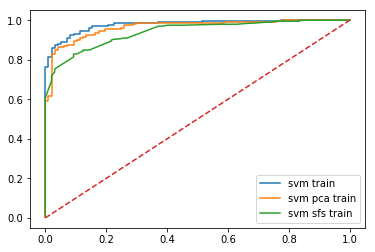

In [552]:
plt.plot(svm_fpr_tr,svm_tpr_tr,label='svm train')
plt.plot(pca_fpr_tr,pca_tpr_tr,label='svm pca train')
plt.plot(sfs_fpr_tr,sfs_tpr_tr,label='svm sfs train')

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

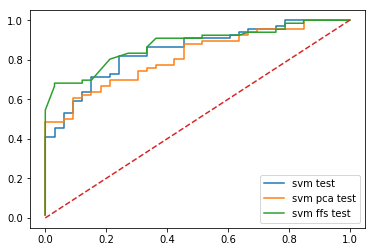

In [553]:
plt.plot(svm_fpr_tt,svm_tpr_tt,label='svm test')
plt.plot(pca_fpr_tt,pca_tpr_tt,label='svm pca test')
plt.plot(sfs_fpr_tt,sfs_tpr_tt,label='svm ffs test')

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

### Classifier 2: Decision Tree

In [560]:
dt_clf = tree.DecisionTreeClassifier(random_state=2018 )
dt_clf.fit(grade_train_X, grade_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2018,
            splitter='best')

In [561]:
print(dt_clf.score(grade_train_X,grade_train_y))
print(dt_clf.score(grade_test_X,grade_test_y))

1.0
0.7878787878787878


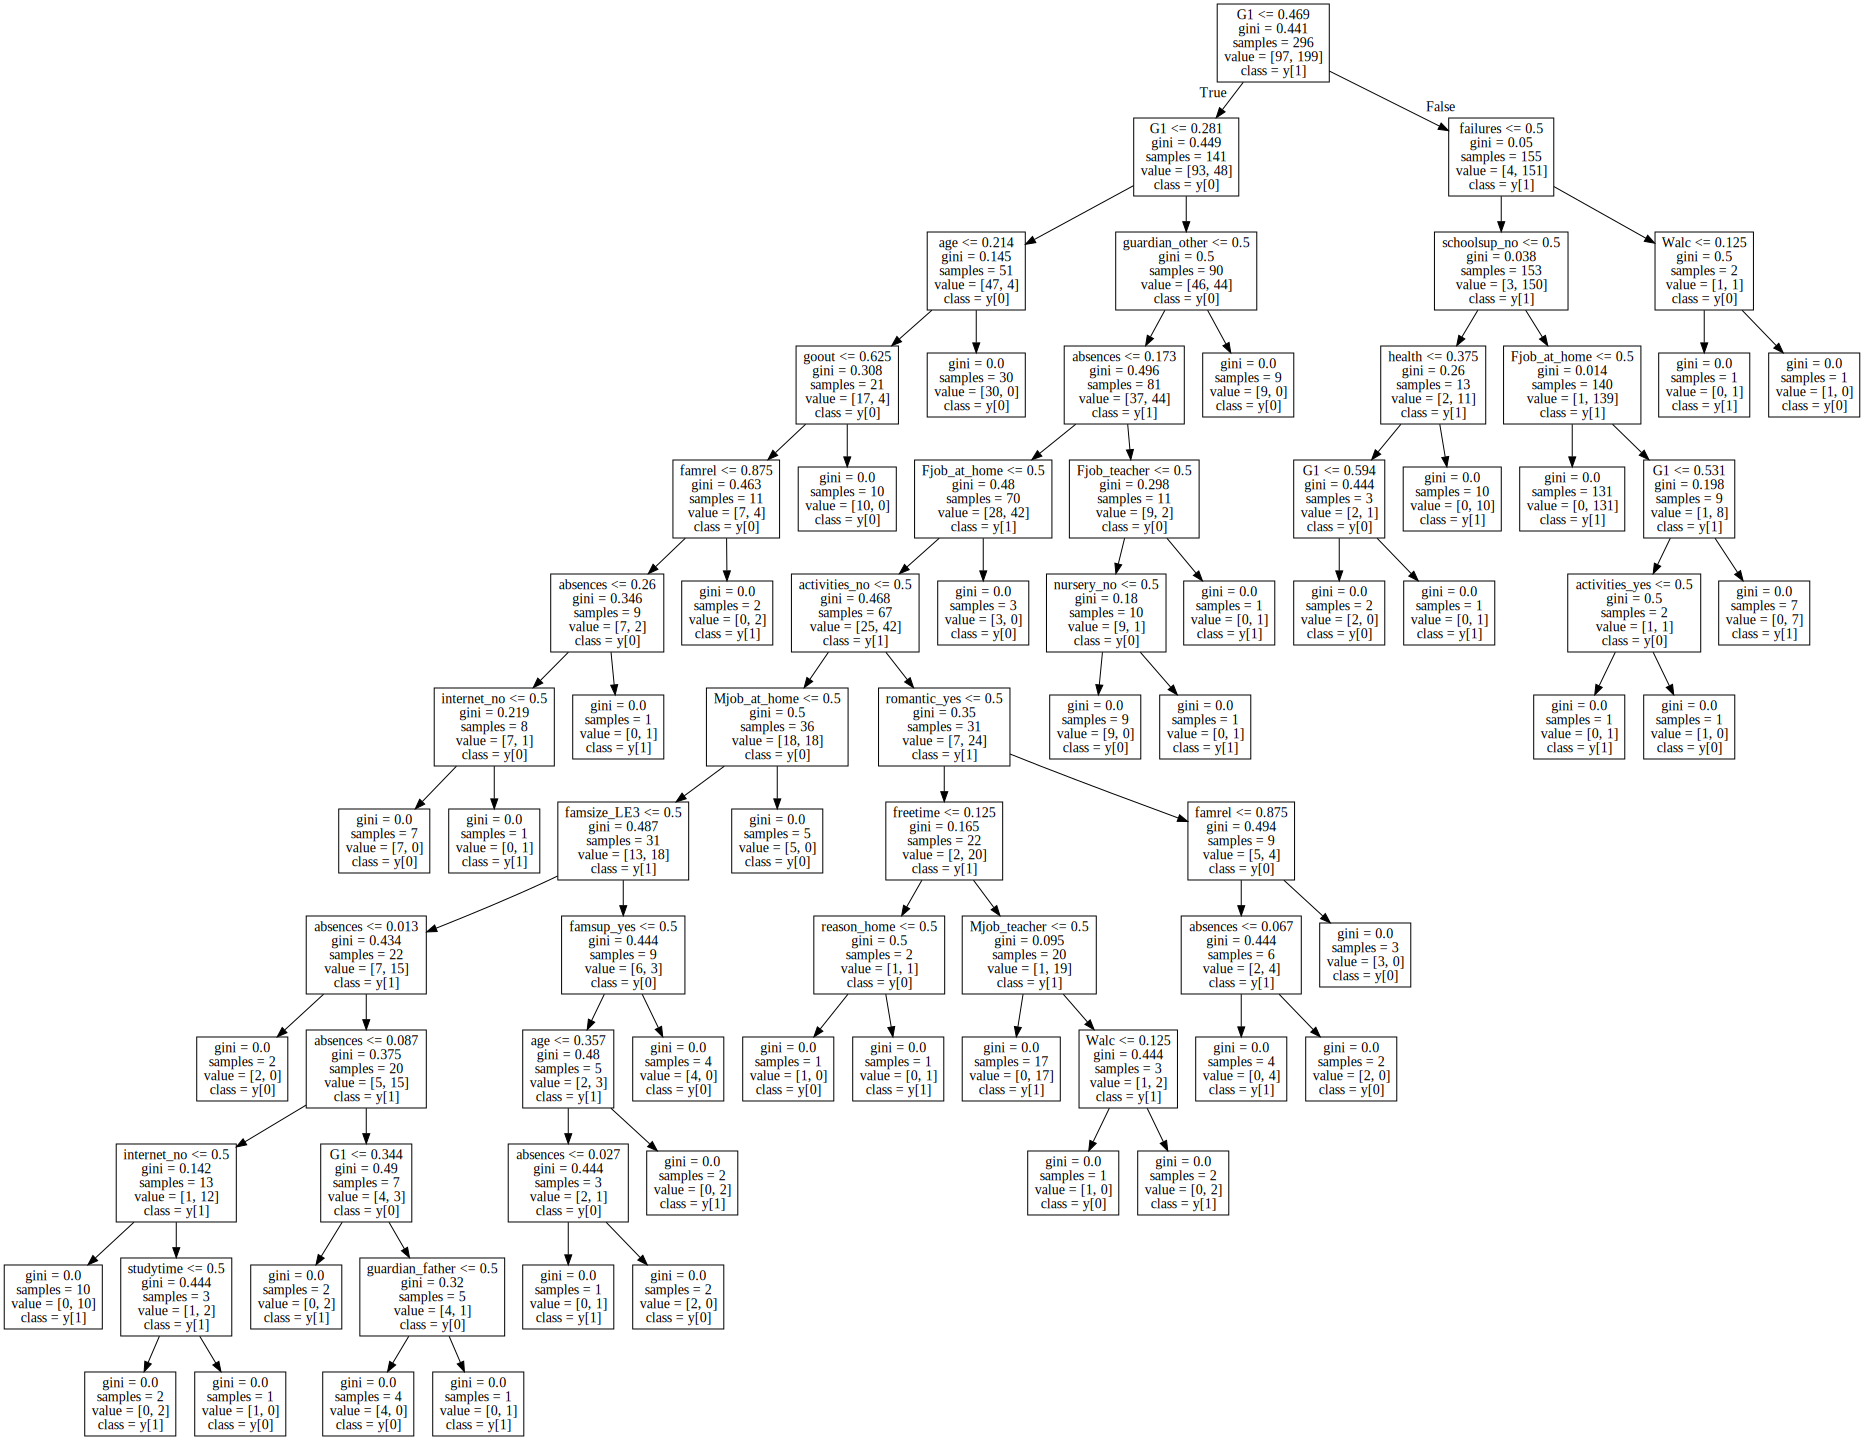

In [562]:
import graphviz 
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                               feature_names=grade_X.columns, 
                               class_names = True) 
graph = graphviz.Source(dot_data) 
graph

#### Tuning Parameters

In [563]:
dt_clf.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [601]:
min_impurity_decreases = np.linspace(0.01,0.4,5)
max_leaf_nodes = np.linspace(4,13,10,dtype=int)
#tuned_parameters = [{'max_leaf_nodes':max_leaf_nodes}]
tuned_parameters = [{'min_samples_split': min_impurity_decreases, 
                     'max_leaf_nodes':max_leaf_nodes}]

clf = GridSearchCV(dt_clf, tuned_parameters, cv=kfold, refit=False)
clf.fit(grade_train_X, grade_train_y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [602]:
scores

array([0.81418919, 0.81418919, 0.81756757, 0.81756757, 0.81756757,
       0.83445946, 0.83445946, 0.81418919, 0.81418919, 0.81756757,
       0.8277027 , 0.84121622, 0.81081081, 0.81418919, 0.81756757,
       0.8277027 , 0.83108108, 0.81081081, 0.81418919, 0.81756757,
       0.83108108, 0.82432432, 0.81081081, 0.81418919, 0.81756757,
       0.8277027 , 0.81756757, 0.81081081, 0.81418919, 0.81756757,
       0.8277027 , 0.81756757, 0.81081081, 0.81418919, 0.81756757,
       0.82094595, 0.81756757, 0.81081081, 0.81418919, 0.81756757,
       0.81756757, 0.81756757, 0.81081081, 0.81418919, 0.81756757,
       0.81418919, 0.81756757, 0.81081081, 0.81418919, 0.81756757])

In [603]:
min_impurity_decreases

array([0.01  , 0.1075, 0.205 , 0.3025, 0.4   ])

In [570]:
max_leaf_nodes

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [571]:
dt_clf.feature_importances_

array([0.01505091, 0.        , 0.        , 0.        , 0.01022294,
       0.00698632, 0.02881009, 0.00564585, 0.01062123, 0.        ,
       0.01789014, 0.01572759, 0.09934121, 0.5690711 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01189428, 0.        , 0.        , 0.00392579,
       0.        , 0.        , 0.01226752, 0.        , 0.        ,
       0.01920307, 0.0076672 , 0.01380096, 0.        , 0.        ,
       0.        , 0.0173495 , 0.        , 0.        , 0.02114539,
       0.02225962, 0.        , 0.        , 0.        , 0.00434475,
       0.01889699, 0.        , 0.        , 0.        , 0.0112917 ,
       0.        , 0.0076672 , 0.        , 0.        , 0.01226752,
       0.        , 0.03665112])

In [572]:
dt_clf_8 = tree.DecisionTreeClassifier(random_state=2018,
                                          max_leaf_nodes = 8)
scores = cross_val_score(dt_clf_8, grade_X, grade_y, cv=kfold)
print_cv(scores)

[0.81012658 0.79746835 0.86075949 0.89873418 0.87341772]
Mean:	 0.848101
Var :	 0.001474


In [578]:
for n in np.arange(5,17,2):
    dt_clf = tree.DecisionTreeClassifier(random_state=2018,
                                              max_leaf_nodes = n)
    #dt_clf_tuned.fit(grade_train_X, grade_train_y)
    scores = cross_val_score(dt_clf, grade_X, grade_y, cv=kfold)
    print(n)
    print_cv(scores)

5
[0.82278481 0.82278481 0.86075949 0.86075949 0.83544304]
Mean:	 0.840506
Var :	 0.000295
7
[0.78481013 0.78481013 0.86075949 0.88607595 0.87341772]
Mean:	 0.837975
Var :	 0.001948
9
[0.79746835 0.78481013 0.86075949 0.89873418 0.87341772]
Mean:	 0.843038
Var :	 0.001961
11
[0.7721519  0.78481013 0.81012658 0.89873418 0.84810127]
Mean:	 0.822785
Var :	 0.002115
13
[0.7721519  0.78481013 0.81012658 0.88607595 0.82278481]
Mean:	 0.815190
Var :	 0.001577
15
[0.78481013 0.78481013 0.79746835 0.89873418 0.83544304]
Mean:	 0.820253
Var :	 0.001884


In [620]:
dt_clf_tuned_5 = tree.DecisionTreeClassifier(random_state=2018,
                                          max_leaf_nodes = 5,
                                          min_impurity_decrease = 0.01)
#dt_clf_tuned.fit(grade_train_X, grade_train_y)
scores = cross_val_score(dt_clf_tuned_5, grade_X, grade_y, cv=kfold)
print_cv(scores)

[0.82278481 0.82278481 0.82278481 0.86075949 0.83544304]
Mean:	 0.832911
Var :	 0.000218


In [621]:
dt_clf_tuned_9 = tree.DecisionTreeClassifier(random_state=2018,
                                          max_leaf_nodes = 9)
#dt_clf_tuned.fit(grade_train_X, grade_train_y)
scores = cross_val_score(dt_clf_tuned_9, grade_X, grade_y, cv=kfold)
print_cv(scores)

[0.79746835 0.78481013 0.86075949 0.89873418 0.87341772]
Mean:	 0.843038
Var :	 0.001961


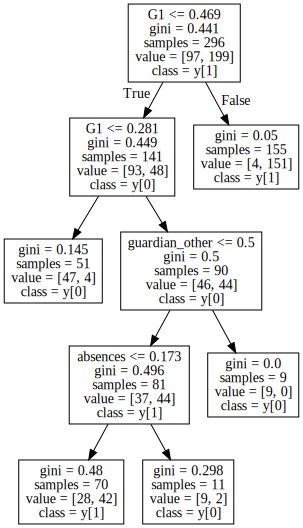

In [624]:
import graphviz 
dt_clf_tuned_5.fit(grade_train_X, grade_train_y)
dot_data = tree.export_graphviz(dt_clf_tuned_5, out_file=None,
                               feature_names=grade_X.columns, 
                               class_names = True) 
graph = graphviz.Source(dot_data) 
graph

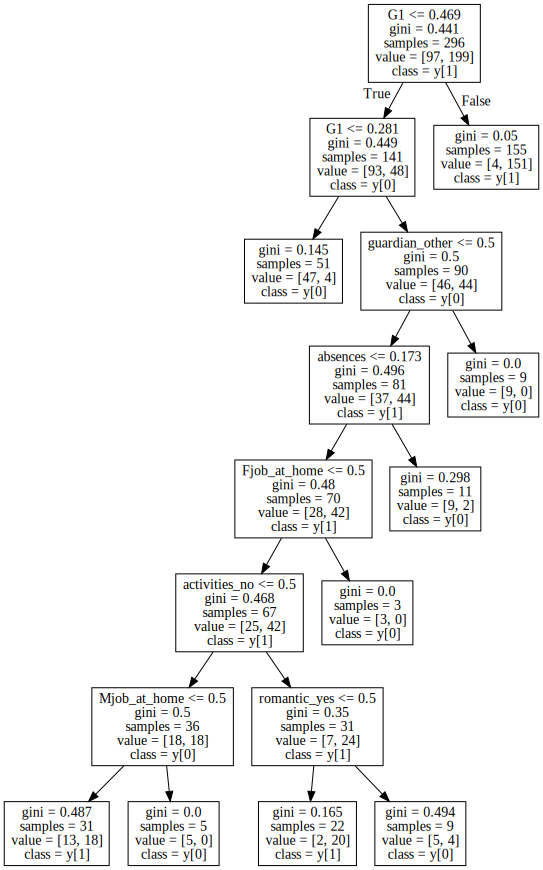

In [625]:
import graphviz 
dt_clf_tuned_9.fit(grade_train_X, grade_train_y)
dot_data = tree.export_graphviz(dt_clf_tuned_9, out_file=None,
                               feature_names=grade_X.columns, 
                               class_names = True) 
graph = graphviz.Source(dot_data) 
graph

In [626]:
cm = confusion_matrix(grade_test_y, dt_clf_tuned_5.predict(grade_test_X))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

dt_recall = tp/(tp+fn)
dt_precision = tp/(tp+fp)
print(dt_recall, dt_precision)

21 12 4 62
0.9393939393939394 0.8378378378378378


In [627]:
cm = confusion_matrix(grade_test_y, dt_clf_tuned_9.predict(grade_test_X))
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

dt_recall = tp/(tp+fn)
dt_precision = tp/(tp+fp)
print(dt_recall, dt_precision)

23 10 8 58
0.8787878787878788 0.8529411764705882
